# **Trabalho Final PDM - Análise de Sentimentos**
#### **Disciplina: Computação Paralela**
#### **Professor: Sávio**

#### **Alunos:**
**- Gustavo Rodrigues Ribeiro / RA:202003570** \
**- Khalil Alves / RA: 202103745** \
**- Keven Lucas / RA: 202000181** \
**- Matheus Leonel / RA:  202109822** \
**- Salvador Ludovico / RA: 202204038**


# **Domínio do Negócio: E-commerce**
### Para este projeto, o domínio de negócio escolhido será o de e-commerce com foco na análise de sentimentos em avaliações de produtos. As avaliações são obtidas de um dataset público de avaliações de produtos eletrônicos, como o Amazon Product Reviews Dataset, que oferece avaliações reais em várias categorias de produtos.

## Iniciando o PySpark

**OBS: Necessário caso utilize Google Coolab ou outra plataforma para criação de códigos em Jupyter Notebook, no entanto, se utilizar o JupyterLab em um Dataproc no Google Cloud Console, essa etapa pode desconsiderada.**

Esta célula de código instala o Spark no ambiente de execução Colab. Aqui está uma explicação passo a passo:

1. **`!apt-get install openjdk-11-jdk-headless -qq > /dev/null`**: este comando instala o OpenJDK 11 (versão headless, sem interface gráfica), que é um requisito para o Spark. O `-qq` suprime a saída e o `> /dev/null` redireciona a saída para o nada, tornando o processo mais silencioso.

2. **`!wget -q https://dlcdn.apache.org/spark/spark-3.5.6/spark-3.5.6-bin-hadoop3.tgz`**: Este comando baixa o arquivo compactado do Spark 3.5.6 (construído para o Hadoop 3) do site oficial do Apache Spark. O `-q` suprime a saída de download.

3. **`!tar xf spark-3.5.6-bin-hadoop3.tgz`**: Este comando extrai o arquivo compactado baixado do Spark, criando um diretório chamado `spark-3.5.6-bin-hadoop3`.

4. **`!pip -q install findspark`**: Este comando instala a biblioteca `findspark` usando `pip`. Findspark é uma biblioteca Python que torna mais fácil configurar o Spark em um ambiente Python, principalmente no Colab. Ela define as variáveis de ambiente necessárias para que o Spark funcione corretamente.

Após executar essas linhas, você terá o Spark instalado e pronto para ser usado em seu notebook Colab.

In [ ]:
!pip install "numpy<2" pandas "pyarrow==14.0.1" pyspark findspark matplotlib seaborn requests

     ---------------------------------------- 0.0/61.0 kB ? eta -:--:--
     ------------ ------------------------- 20.5/61.0 kB 320.0 kB/s eta 0:00:01
     ------------------------- ------------ 41.0/61.0 kB 393.8 kB/s eta 0:00:01
     -------------------------------------- 61.0/61.0 kB 461.8 kB/s eta 0:00:00
  Using cached pandas-2.3.0-cp311-cp311-win_amd64.whl.metadata (19 kB)
  Using cached pyarrow-14.0.1-cp311-cp311-win_amd64.whl.metadata (3.1 kB)
  Using cached pyspark-4.0.0-py2.py3-none-any.whl
  Using cached findspark-2.0.1-py2.py3-none-any.whl.metadata (352 bytes)
  Using cached matplotlib-3.10.3-cp311-cp311-win_amd64.whl.metadata (11 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached requests-2.32.4-py3-none-any.whl.metadata (4.9 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached py4j-0.10.9.9-py2.py3-none-any.whl.metadata (1.3 kB)
  Using cach


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Conexão Via Unix/Colab/GCP

In [ ]:
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://dlcdn.apache.org/spark/spark-3.5.6/spark-3.5.6-bin-hadoop3.tgz
!tar xf spark-3.5.6-bin-hadoop3.tgz
!pip -q install findspark

Defina as variáveis de ambiente do Spark:

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.6-bin-hadoop3"

O código a seguir garante que o Spark seja configurado corretamente e esteja pronto para uso em seu ambiente Python.

* **`findspark.init()`**: executa a função `init()` do módulo `findspark`. Esta função:
    * Localiza a instalação do Spark em seu sistema.
    * Configura as variáveis de ambiente necessárias para que o Python possa interagir com o Spark. Isso permite que o driver Python (seu código Python) se comunique com o executor Spark (o código que realmente processa os dados).


In [ ]:
import findspark
findspark.init()

## Conexão Via Windows

Depois de executar a célula anterior, você poderá importar e usar as bibliotecas Spark como `pyspark.sql.SparkSession` para criar uma sessão Spark e começar a trabalhar com dados.

In [ ]:
import os
import requests
import tarfile
import sys

# --- 1. Baixar o Spark (substitui o wget) ---
spark_version = "3.5.6"  # Usando uma versão estável e popular
hadoop_version = "3"
spark_url = f"https://dlcdn.apache.org/spark/spark-3.5.6/spark-3.5.6-bin-hadoop3.tgz"
spark_filename = os.path.basename(spark_url)
spark_foldername = spark_filename.replace(".tgz", "")

print(f"Baixando {spark_filename}...")
# Faz o download apenas se o arquivo não existir
if not os.path.exists(spark_filename):
    response = requests.get(spark_url, stream=True)
    if response.status_code == 200:
        with open(spark_filename, "wb") as f:
            f.write(response.raw.read())
        print("Download completo.")
    else:
        print(f"Erro ao baixar o arquivo. Status: {response.status_code}")
else:
    print("Arquivo Spark já existe, pulando download.")

# --- 2. Extrair o Spark (substitui o tar) ---
print(f"Extraindo {spark_filename}...")
# Extrai apenas se a pasta de destino não existir
if not os.path.exists(spark_foldername):
    with tarfile.open(spark_filename, "r:gz") as tar:
        tar.extractall()
    print("Extração completa.")
else:
    print("Pasta do Spark já existe, pulando extração.")

!pip -q install findspark

print("\nConfiguração inicial concluída!")

Baixando spark-3.5.6-bin-hadoop3.tgz...
Arquivo Spark já existe, pulando download.
Extraindo spark-3.5.6-bin-hadoop3.tgz...
Pasta do Spark já existe, pulando extração.

Configuração inicial concluída!



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import os
import findspark

# --- Configurar as Variáveis de Ambiente para o Python ---

# Caminho para a pasta do Spark que foi extraída
# Use os.path.abspath para garantir um caminho absoluto e compatível com Windows
spark_home = os.path.abspath("spark-3.5.6-bin-hadoop3")

# ATENÇÃO: Verifique se este caminho do JAVA_HOME está correto para a sua máquina!
# Deve ser o mesmo que você configurou nas variáveis de ambiente do Windows.
java_home = r"C:\Program Files\Java\zulu21.34.19-ca-jdk21.0.3-win_x64"
hadoop_home = r"C:\hadoop-3.3.6"

print(f"SPARK_HOME: {spark_home}")
print(f"JAVA_HOME: {java_home}")
print(f"HADOOP_HOME: {hadoop_home}")

# Define as variáveis de ambiente para a sessão atual
os.environ["SPARK_HOME"] = spark_home
os.environ["JAVA_HOME"] = java_home
os.environ["HADOOP_HOME"] = hadoop_home

# Adiciona os binários do Spark e Hadoop ao PATH do sistema
os.environ["PATH"] = f"{os.environ['SPARK_HOME']}\\bin;{os.environ['HADOOP_HOME']}\\bin;{os.environ['PATH']}"

# --- Inicializar o findspark ---
findspark.init()

SPARK_HOME: c:\Users\gusta\Desktop\TrabalhoFinalCP\spark-3.5.6-bin-hadoop3
JAVA_HOME: C:\Program Files\Java\zulu21.34.19-ca-jdk21.0.3-win_x64
HADOOP_HOME: C:\hadoop-3.3.6


## Conectando ao Drive

Aqui estaremos sincronizando nossa conta no Drive ao ambiente Colab, para que os arquivos em nuvem sejam gerenciados (lidos e escritos) e manipulados diretamente no Drive.

**OBS: Caso esteja utilizando o Dataproc do Google Cloud Console, com o ambiente virtual Jupyter Notebook, você podera utilizar o Data Lake Google Cloud Storage (GCS) que está conectado a sua conta, não necessitando desse processo de sincronização com o Drive.**

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!ls /content/drive

MyDrive  Shareddrives


## Importações e Função Para Criação da Sessão Spark

In [ ]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.functions import *
from pyspark.sql.types import FloatType
from pyspark.storagelevel import StorageLevel
from pyspark.ml import Pipeline
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, IDF
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import PipelineModel
import os

Função para criação da sessão

In [ ]:
def get_spark_session(cores):
    """Cria uma sessão Spark em modo local com um número definido de cores."""
    return SparkSession.builder \
        .appName(f"GoldLayerAnalysis_Cores_{cores}") \
        .master(f"local[{cores}]") \
        .config("spark.driver.memory", "32g") \
        .getOrCreate()

## **Arquitetura Medallion: Gold - Feature Engineering e Modelagem de IA**

Função da Tarefa a ser Medida (Processamento da Camada Gold)

In [ ]:
def run_gold_layer_task(spark, input_path):
    """
    Executa o pipeline completo da Camada Gold: pré-processamento, balanceamento
    e treinamento do modelo de Machine Learning.
    """
    print(f"Lendo dados da Camada Silver de: {input_path}")
    reviews_df_gold = spark.read.parquet(input_path)
    #reviews_df_gold = reviews_df_gold.sample(fraction=0.1)  # 10% dos dados
    print(f"Quantidade de reviews utilizadas: {reviews_df_gold.count()}")

    print("Dividindo dados em treino (80%) e teste (20%)...")
    train_df, test_df = reviews_df_gold.randomSplit([0.8, 0.2], seed=42)

    # Cache dos dataframes é crucial para o desempenho do treinamento iterativo
    train_df.persist(StorageLevel.MEMORY_AND_DISK)
    test_df.persist(StorageLevel.MEMORY_AND_DISK)

    # --- Balanceamento de Classes (Class Weights) ---
    print("Calculando pesos para balanceamento de classes (operação com .collect)...")
    class_distribution = train_df.groupBy("sentimentOverall").count()
    total_count = class_distribution.agg(sum("count")).collect()[0][0] # Ponto de sincronização
    class_weights_df = class_distribution.withColumn("classWeight", lit(total_count) / col("count"))
    class_weights = {row['sentimentOverall']: row["classWeight"] for row in class_weights_df.collect()}

    weight_udf = udf(lambda sentiment: class_weights.get(sentiment, 1.0), FloatType())
    train_df_weighted = train_df.withColumn("classWeight", weight_udf(col("sentimentOverall")))

    # --- Definição do Pipeline de ML ---
    print("Definindo o pipeline de ML (Tokenizer, StopWords, Vectorizer, IDF, LogisticRegression)...")
    tokenizer = Tokenizer(inputCol="reviewText", outputCol="words")
    stopwords_remover = StopWordsRemover(inputCol="words", outputCol="filteredWords")
    vectorizer = CountVectorizer(inputCol="filteredWords", outputCol="rawFeatures")
    idf = IDF(inputCol="rawFeatures", outputCol="features")
    lr = LogisticRegression(labelCol="sentimentOverall", featuresCol="features", maxIter=10, family="multinomial", weightCol="classWeight")
    pipeline = Pipeline(stages=[tokenizer, stopwords_remover, vectorizer, idf, lr])

    # --- Treinamento do Modelo (A etapa mais intensiva) ---
    print("Iniciando o treinamento do modelo... Esta é a etapa mais demorada.")
    spark_model = pipeline.fit(train_df_weighted)
    print("Treinamento concluído.")

    # Liberar a memória cacheada
    train_df.unpersist()
    test_df.unpersist()

    print("Tarefa da Camada Gold concluída.")

    return spark_model,test_df

Definindo Caminhos

In [ ]:
# Defina os caminhos para seus dados
gold_input_path = r"C:\Users\gusta\Desktop\TrabalhoFinalCP\data\Silver\reviews_silver"
gold_output_path = r"C:\Users\gusta\Desktop\TrabalhoFinalCP\data\Gold\logistc_regression_model"
test_df_gold_output_path = r"C:\Users\gusta\Desktop\TrabalhoFinalCP\data\Gold\test_df"

## Avaliações

In [ ]:
# Lista de número de cores para testar. O '1' representa o modo sequencial.
core_counts = [1, 2, 4, 6]  # Ajuste para os núcleos da sua máquina
results = []

print("Iniciando experimento de desempenho da Camada Gold...")
print(f"Dataset de entrada: {gold_input_path}")

for cores in core_counts:
    print(f"\n---------- EXECUTANDO COM {cores} CORE(S) ----------")

    spark = get_spark_session(cores)
    start_time = time.time()

    model_current_run,test_df_current_run = run_gold_layer_task(spark, gold_input_path)

    end_time = time.time()
    execution_time = end_time - start_time

    results.append({
        "num_cores": cores,
        "execution_time": execution_time
    })

    print(f"Tempo de execução: {execution_time:.2f} segundos")

    # Se esta for a última iteração (ou a que você quer salvar), mantenha a referência ao DataFrame antes de parar a sessão.
    if cores == core_counts[-1]:
        model = model_current_run
        test_df = test_df_current_run
    else:
        # Para a sessão para liberar recursos para iterações futuras
        spark.stop()

if model is not None:
    print(f"\nSalvando o modelo treinado da Camada Gold em: {gold_output_path}")
    # Salva o DataFrame como tabela da camada Silver (formato .parquet)
    model.write().overwrite().save(gold_output_path)
    test_df.write.mode("overwrite").option("header", True).parquet(test_df_gold_output_path)
    spark.stop()
else:
    print("Nenhum modelo para salvar após o loop.")

Iniciando experimento de desempenho da Camada Gold...
Dataset de entrada: C:\Users\gusta\Desktop\TrabalhoFinalCP\data\Silver\reviews_silver

---------- EXECUTANDO COM 1 CORE(S) ----------
Lendo dados da Camada Silver de: C:\Users\gusta\Desktop\TrabalhoFinalCP\data\Silver\reviews_silver
Quantidade de reviews utilizadas: 5202047
Dividindo dados em treino (80%) e teste (20%)...
Calculando pesos para balanceamento de classes (operação com .collect)...
Definindo o pipeline de ML (Tokenizer, StopWords, Vectorizer, IDF, LogisticRegression)...
Iniciando o treinamento do modelo... Esta é a etapa mais demorada.
Treinamento concluído.
Tarefa da Camada Gold concluída.
Tempo de execução: 681.29 segundos

---------- EXECUTANDO COM 2 CORE(S) ----------
Lendo dados da Camada Silver de: C:\Users\gusta\Desktop\TrabalhoFinalCP\data\Silver\reviews_silver
Quantidade de reviews utilizadas: 5202047
Dividindo dados em treino (80%) e teste (20%)...
Calculando pesos para balanceamento de classes (operação com .

## Análise e Visualização dos Resultados Geração do Modelo



#### Análise Final de Desempenho da Camada Gold (Geração do Modelo) ####


--- Tabela de Resultados ---

                 cores  execution_time  speedup  efficiency
0  Sequencial (1 Core)          681.29     1.00        1.00
1   Paralelo (2 Cores)          353.82     1.93        0.96
2   Paralelo (4 Cores)          198.18     3.44        0.86
3   Paralelo (6 Cores)          171.87     3.96        0.66


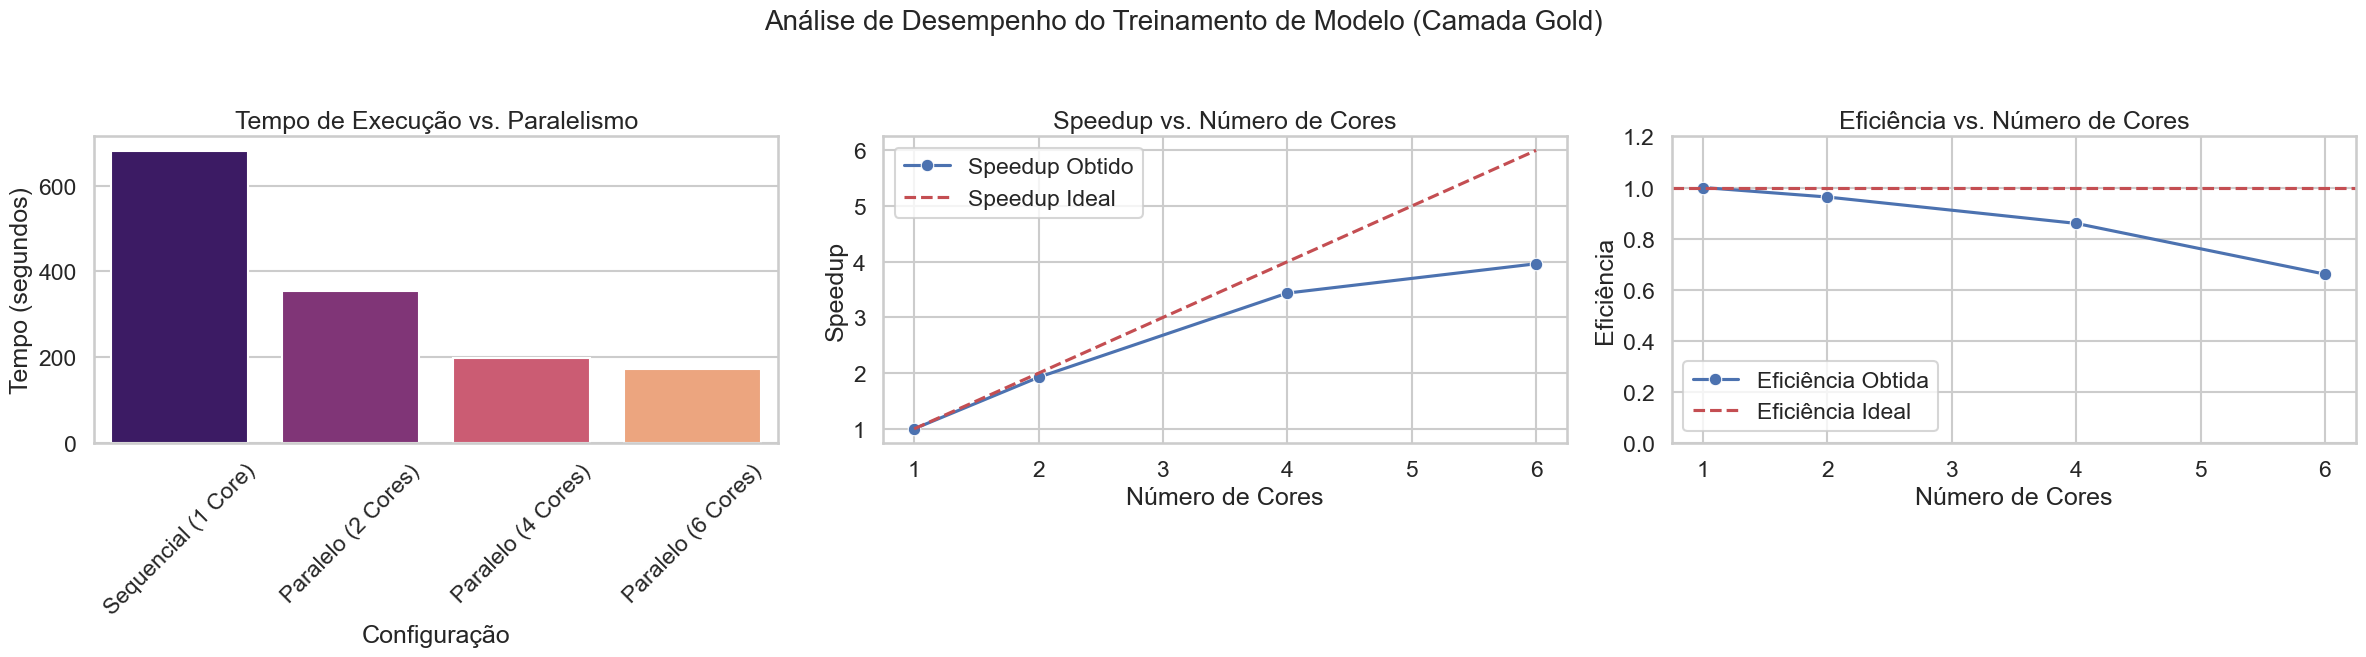

In [ ]:
print("\n\n#### Análise Final de Desempenho da Camada Gold (Geração do Modelo) ####\n\n")

results_df = pd.DataFrame(results)
results_df['cores'] = results_df['num_cores'].apply(lambda x: 'Sequencial (1 Core)' if x == 1 else f'Paralelo ({x} Cores)')

sequential_time = results_df.loc[results_df['num_cores'] == 1, 'execution_time'].iloc[0]
results_df['speedup'] = sequential_time / results_df['execution_time']
results_df['efficiency'] = results_df['speedup'] / results_df['num_cores']

print("--- Tabela de Resultados ---\n")
print(results_df[['cores', 'execution_time', 'speedup', 'efficiency']].round(2))

sns.set_theme(style="whitegrid", context="talk")
fig, axes = plt.subplots(1, 3, figsize=(24, 7))
fig.suptitle('Análise de Desempenho do Treinamento de Modelo (Camada Gold)', fontsize=20)

sns.barplot(ax=axes[0], x='cores', y='execution_time', data=results_df, palette='magma', hue='cores', legend=False)
axes[0].set_title('Tempo de Execução vs. Paralelismo')
axes[0].set_xlabel('Configuração')
axes[0].set_ylabel('Tempo (segundos)')
axes[0].tick_params(axis='x', rotation=45)

sns.lineplot(ax=axes[1], x='num_cores', y='speedup', data=results_df, marker='o', label='Speedup Obtido')
axes[1].plot(results_df['num_cores'], results_df['num_cores'], linestyle='--', color='r', label='Speedup Ideal')
axes[1].set_title('Speedup vs. Número de Cores')
axes[1].set_xlabel('Número de Cores')
axes[1].set_ylabel('Speedup')
axes[1].legend()

sns.lineplot(ax=axes[2], x='num_cores', y='efficiency', data=results_df, marker='o', label='Eficiência Obtida')
axes[2].axhline(y=1.0, linestyle='--', color='r', label='Eficiência Ideal')
axes[2].set_title('Eficiência vs. Número de Cores')
axes[2].set_xlabel('Número de Cores')
axes[2].set_ylabel('Eficiência')
axes[2].set_ylim(0, 1.2)
axes[2].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Avaliação do Modelo

Devemos realizar o balanceamento da classe de testes

In [ ]:
def run_df_distribution(test_df):

    # Contar a quantidade de amostras por classe
    class_distribution_test = test_df.groupBy("sentimentOverall").count()

    # Identificar a classe minoritária
    minority_class_count_test = class_distribution_test.orderBy("count").first()["count"]

    # Função para realizar o undersampling nas classes majoritárias
    def undersample(df: DataFrame, label_col: str, minority_class_count: int, class_distribution: DataFrame) -> DataFrame:
        sampled_dfs = []

        # Iterar sobre cada classe
        for row in class_distribution.collect():
            label = row["sentimentOverall"]
            count = row["count"]

            # Se a classe for majoritária, aplicar undersampling
            if count > minority_class_count:
                sampled_df = df.filter(col(label_col) == label).sample(fraction=minority_class_count / count, seed=42)
            else:
                sampled_df = df.filter(col(label_col) == label)

            sampled_dfs.append(sampled_df)

        # Combinar todas as classes balanceadas
        balanced_df = sampled_dfs[0]
        for df_part in sampled_dfs[1:]:
            balanced_df = balanced_df.union(df_part)

        return balanced_df

    # Aplicar o undersampling no DataFrame de teste
    distributed_test_df = undersample(test_df, "sentimentOverall", minority_class_count_test, class_distribution_test)

    return distributed_test_df

Função para a realização da avaliação do modelo

In [ ]:
def run_model_avaliation(spark, model_input_path, test_df_input_path):

    # Carrega modelo salvo anteriormente
    model = PipelineModel.load(model_input_path)

    # Balanceando o Dataframe de testes
    test_df = spark.read.parquet(test_df_input_path)
    distributed_test_df = run_df_distribution(test_df)

    #### --------------------------------------- Avaliação do Modelo ----------------------------------------- ####

    # Previsão no conjunto de dados de teste
    predictions = model.transform(distributed_test_df)

    # Avaliar acurácia
    accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="sentimentOverall", predictionCol="prediction", metricName="accuracy")
    accuracy = accuracy_evaluator.evaluate(predictions)

    # Avaliar precisão média
    precision_evaluator = MulticlassClassificationEvaluator(labelCol="sentimentOverall", predictionCol="prediction", metricName="weightedPrecision")
    precision = precision_evaluator.evaluate(predictions)

    # Avaliar revocação
    recall_evaluator = MulticlassClassificationEvaluator(labelCol="sentimentOverall", predictionCol="prediction", metricName="weightedRecall")
    recall = recall_evaluator.evaluate(predictions)

    # Avaliar F1-Score
    f1_evaluator = MulticlassClassificationEvaluator(labelCol="sentimentOverall", predictionCol="prediction", metricName="f1")
    f1_score = f1_evaluator.evaluate(predictions)

    print("---- Resultados da Avaliação ----\n")

    # Imprimir os resultados
    print(f"Acurácia: {accuracy:.2f}")
    print(f"Precisão Média: {precision:.2f}")
    print(f"Revocação Média: {recall:.2f}")
    print(f"F1-Score: {f1_score:.2f}")

In [ ]:
# Lista de número de cores para testar. O '1' representa o modo sequencial.
core_counts = [1, 2, 4, 6]  # Ajuste para os núcleos da sua máquina
results_avaliation = []

print("Iniciando avaliação do modelo Spark...")

for cores in core_counts:
    print(f"\n---------- EXECUTANDO COM {cores} CORE(S) ----------")

    spark = get_spark_session(cores)
    start_time = time.time()

    run_model_avaliation(spark, gold_output_path, test_df_gold_output_path)

    end_time = time.time()
    execution_time = end_time - start_time

    results_avaliation.append({
        "num_cores": cores,
        "execution_time": execution_time
    })

    print(f"Tempo de execução: {execution_time:.2f} segundos")

    # Finaliza a sessão Spark
    spark.stop()

Iniciando avaliação do modelo Spark...

---------- EXECUTANDO COM 1 CORE(S) ----------
---- Resultados da Avaliação ----

Acurácia: 0.67
Precisão Média: 0.67
Revocação Média: 0.67
F1-Score: 0.67
Tempo de execução: 58.07 segundos

---------- EXECUTANDO COM 2 CORE(S) ----------
---- Resultados da Avaliação ----

Acurácia: 0.67
Precisão Média: 0.67
Revocação Média: 0.67
F1-Score: 0.67
Tempo de execução: 35.52 segundos

---------- EXECUTANDO COM 4 CORE(S) ----------
---- Resultados da Avaliação ----

Acurácia: 0.67
Precisão Média: 0.67
Revocação Média: 0.67
F1-Score: 0.67
Tempo de execução: 20.90 segundos

---------- EXECUTANDO COM 6 CORE(S) ----------
---- Resultados da Avaliação ----

Acurácia: 0.68
Precisão Média: 0.67
Revocação Média: 0.68
F1-Score: 0.67
Tempo de execução: 19.95 segundos


## Análise e Visualização dos Resultados Avaliação



#### Análise Final de Desempenho da Camada Gold (Avaliação) ####


--- Tabela de Resultados ---

                 cores  execution_time  speedup  efficiency
0  Sequencial (1 Core)           58.07     1.00        1.00
1   Paralelo (2 Cores)           35.52     1.64        0.82
2   Paralelo (4 Cores)           20.90     2.78        0.69
3   Paralelo (6 Cores)           19.95     2.91        0.49


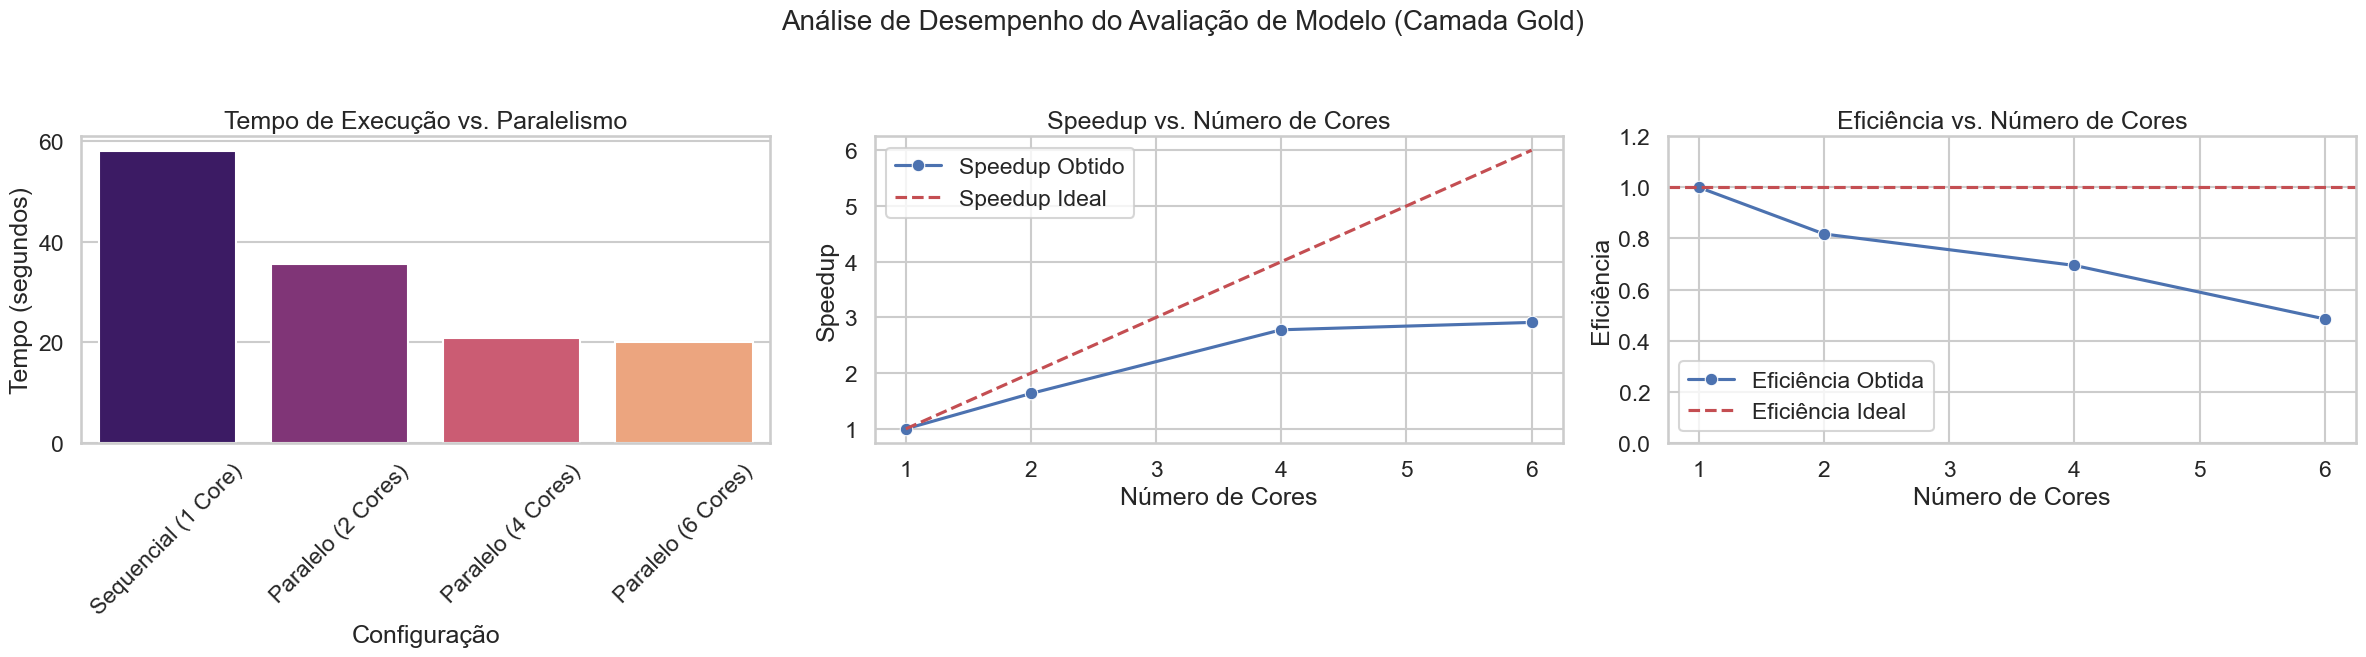

In [ ]:
print("\n\n#### Análise Final de Desempenho da Camada Gold (Avaliação) ####\n\n")

results_df = pd.DataFrame(results_avaliation)
results_df['cores'] = results_df['num_cores'].apply(lambda x: 'Sequencial (1 Core)' if x == 1 else f'Paralelo ({x} Cores)')

sequential_time = results_df.loc[results_df['num_cores'] == 1, 'execution_time'].iloc[0]
results_df['speedup'] = sequential_time / results_df['execution_time']
results_df['efficiency'] = results_df['speedup'] / results_df['num_cores']

print("--- Tabela de Resultados ---\n")
print(results_df[['cores', 'execution_time', 'speedup', 'efficiency']].round(2))

sns.set_theme(style="whitegrid", context="talk")
fig, axes = plt.subplots(1, 3, figsize=(24, 7))
fig.suptitle('Análise de Desempenho do Avaliação de Modelo (Camada Gold)', fontsize=20)

sns.barplot(ax=axes[0], x='cores', y='execution_time', data=results_df, palette='magma', hue='cores', legend=False)
axes[0].set_title('Tempo de Execução vs. Paralelismo')
axes[0].set_xlabel('Configuração')
axes[0].set_ylabel('Tempo (segundos)')
axes[0].tick_params(axis='x', rotation=45)

sns.lineplot(ax=axes[1], x='num_cores', y='speedup', data=results_df, marker='o', label='Speedup Obtido')
axes[1].plot(results_df['num_cores'], results_df['num_cores'], linestyle='--', color='r', label='Speedup Ideal')
axes[1].set_title('Speedup vs. Número de Cores')
axes[1].set_xlabel('Número de Cores')
axes[1].set_ylabel('Speedup')
axes[1].legend()

sns.lineplot(ax=axes[2], x='num_cores', y='efficiency', data=results_df, marker='o', label='Eficiência Obtida')
axes[2].axhline(y=1.0, linestyle='--', color='r', label='Eficiência Ideal')
axes[2].set_title('Eficiência vs. Número de Cores')
axes[2].set_xlabel('Número de Cores')
axes[2].set_ylabel('Eficiência')
axes[2].set_ylim(0, 1.2)
axes[2].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Análise

O treinamento do modelo, uma tarefa intensiva em CPU, demonstrou o ganho de desempenho mais significativo. A natureza iterativa do algoritmo de Regressão Logística foi distribuída eficientemente entre os núcleos, resultando em um speedup expressivo.

A eficiência diminui ligeiramente com mais núcleos devido ao overhead de comunicação e a pontos de sincronização (como a coleta de pesos de classe), um exemplo prático da Lei de Amdahl. Apesar da redução de eficiência, o tempo total de execução continua diminuindo, o que reforça a vantagem da paralelização quando aplicada de forma estratégica.
